
According to scikit learn this would be a binary classificiation model and according to the cheat sheet this could work with SVC and then if it doesnt work we can:

1) For text data: naive bayes

2) Non text data: K nn classifier or svc ensemble classifier

We decide to do straightly a multimodal model so that for each feature we would train a number between 0 and 1, then maybe with these results try to fit the weight of those features to predict the free pass. 

Is a multimodal model the best approach? Does it matter if we do 0 to 1 or -1 to 1 scores for individual features?  

Later on, we can extract for example the positivity of text as a score. there are libraries for that. 

Import file and check everything looks nice 

In [1]:
import pandas as pd
#create dataframe

data=pd.read_csv('../data/train.csv')
#data.head()
print(data.info())
print("\nShape: ",data.shape)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10116 non-null  object 
 1   PreferedAlbum  9881 non-null   object 
 2   Vinyl          9867 non-null   object 
 3   AvgTime        10116 non-null  float64
 4   TicketInfo     9885 non-null   object 
 5   Opinion        8613 non-null   object 
 6   Concert        9900 non-null   object 
 7   Age            9900 non-null   float64
 8   VIP            9881 non-null   object 
 9   Food           10116 non-null  float64
 10  Drinks         10116 non-null  float64
 11  FreePass       10116 non-null  bool   
dtypes: bool(1), float64(4), object(7)
memory usage: 879.4+ KB
None

Shape:  (10116, 12)


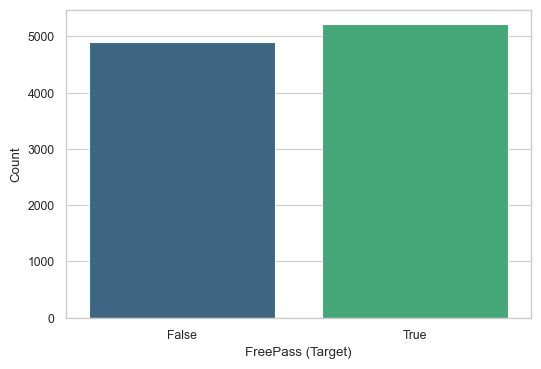

FreePass
True     51.561882
False    48.438118
Name: proportion, dtype: float64


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration: Paper style, compact figures
sns.set_theme(style="whitegrid", context="paper")
plt.rc('figure', figsize=(6, 4))
# Visualize Target Balance
sns.countplot(x='FreePass', data=data, hue='FreePass', palette='viridis', legend=False)
plt.ylabel('Count')
plt.xlabel('FreePass (Target)')
plt.show()

# Print exact percentages
print(data['FreePass'].value_counts(normalize=True) * 100)

In [3]:

print(f"Missing values: {data.isnull().sum().sum()}")


# 2. Impute Numerical Columns with Median
print(f"Missing values in Age: {data['Age'].isnull().sum()}")
data['Age'] = data['Age'].fillna(data['Age'].median())



# 3. Impute Categorical Columns with Mode
print(f"Missing values in Concert: {data['Concert'].isnull().sum()}")
print(f"Missing values in TicketInfo: {data['TicketInfo'].isnull().sum()}")
print(f"Missing values in PreferedAlbum: {data['PreferedAlbum'].isnull().sum()}")
print(f"Missing values in Vinyl: {data['Vinyl'].isnull().sum()}")
print(f"Missing values in VIP: {data['VIP'].isnull().sum()}")


cat_cols = ['Concert', 'TicketInfo', 'PreferedAlbum', 'Vinyl', 'VIP']
for col in cat_cols:
    # Mode returns a series, we take the first element [0]
    data[col] = data[col].fillna(data[col].mode()[0])

print(f"Still missing values: {data.isnull().sum().sum()}")


Missing values: 2885
Missing values in Age: 216
Missing values in Concert: 216
Missing values in TicketInfo: 231
Missing values in PreferedAlbum: 235
Missing values in Vinyl: 249
Missing values in VIP: 235
Still missing values: 1503


C:\Users\Ale\AppData\Local\Temp\ipykernel_28824\2274427063.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(data[col].mode()[0])


We can do better than treat opinion as the other non numerical values by converting it to numerical using percieved feeling in it. 

In [4]:

print("Opinion missing values: ", data['Opinion'].isnull().sum())

from textblob import TextBlob

# Apply sentiment analysis to every row
# We cast to string first to avoid errors with non-string data
data['Opinion_Polarity'] = data['Opinion'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Compare raw text vs new score
print(data[['Opinion', 'Opinion_Polarity']].head())

Opinion missing values:  1503
                                             Opinion  Opinion_Polarity
0  Everything worked, yet nothing surprised me. (...          0.100000
1  Solid gig—nothing magical, nothing awful. (NYC...         -0.166667
2  Guitars were sharp, but everything else felt r...         -0.125000
3  Feedback screamed louder than the guitars. Dis...          0.000000
4                                                NaN          0.000000


Now we are going to extract some information about the concert to treat location and time as separate variables

C:\Users\Ale\AppData\Local\Temp\ipykernel_28824\894213880.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FreePass', y='Concert_City', data=data, palette='viridis', orient='h')


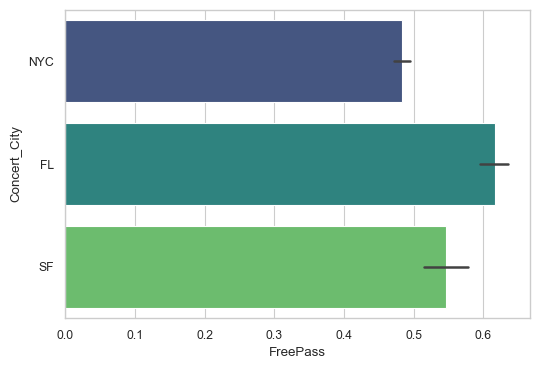

Concert_City
NYC    7132
FL     2068
SF      916
Name: count, dtype: int64


In [5]:
# Extract the City using Regex (captures the starting letters)
data['Concert_City'] = data['Concert'].astype(str).str.extract(r'^([A-Za-z]+)')

# Visualize if location affects the FreePass chance
sns.barplot(x='FreePass', y='Concert_City', data=data, palette='viridis', orient='h')
plt.title('') # No title as requested
plt.show()

# Check how many unique cities we found
print(data['Concert_City'].value_counts())

C:\Users\Ale\AppData\Local\Temp\ipykernel_28824\77573141.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FreePass', y='Concert_Duration', data=data, palette='viridis', orient='h')


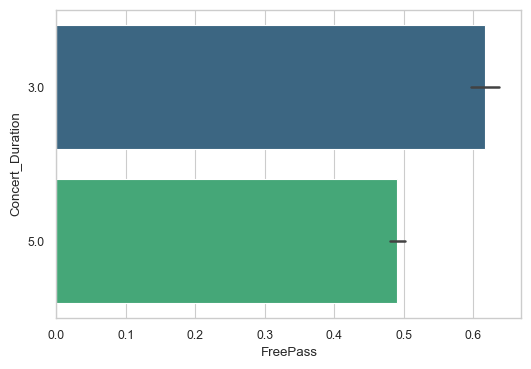

Concert_Duration
5.0    8048
3.0    2068
Name: count, dtype: int64


In [6]:
# Extract the City using Regex (captures the starting letters)
# Extract start time (the first number before the dash)
data['Concert_StartTime'] = data['Concert'].astype(str).str.extract(r'([A-Za-z]+)(\d+)-', expand=False)[1].astype(float)

# Extract end time (the number after the dash, before 'pm')
data['Concert_EndTime'] = data['Concert'].astype(str).str.extract(r'-(\d+)pm').astype(float)

# Calculate duration in hours
data['Concert_Duration'] = 12+data['Concert_EndTime'] - data['Concert_StartTime']

# Visualize if location affects the FreePass chance
sns.barplot(x='FreePass', y='Concert_Duration', data=data, palette='viridis', orient='h')

plt.show()

# Check how many unique cities we found
print(data['Concert_Duration'].value_counts())

# We can now drop the original Concert column
data = data.drop(columns=['Concert'])

In [7]:
data.columns

Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'TicketInfo', 'Opinion',
       'Age', 'VIP', 'Food', 'Drinks', 'FreePass', 'Opinion_Polarity',
       'Concert_City', 'Concert_StartTime', 'Concert_EndTime',
       'Concert_Duration'],
      dtype='object')

What about the ticket info? We can also try to extract info naively

In [8]:
# Function to parse the ticket string
def split_ticket(ticket):
    try:
        parts = str(ticket).split('/')
        # Returns (TicketType, TicketClass)
        # Example: 'CB/734/XL' -> 'CB', 'XL'
        return parts[0], parts[-1]
    except:
        return 'Unknown', 'Unknown'

# Apply function and create two new columns
data[['Ticket_Type', 'Ticket_Class']] = data['TicketInfo'].apply(
    lambda x: pd.Series(split_ticket(x))
)

# See the count of each new category
print("Ticket Types:\n", data['Ticket_Type'].value_counts().head())
print("\nTicket Classes:\n", data['Ticket_Class'].value_counts())

Ticket Types:
 Ticket_Type
LB    3297
CB    3176
B     1057
A      907
LT     855
Name: count, dtype: int64

Ticket Classes:
 Ticket_Class
XL    5241
N     4875
Name: count, dtype: int64


The rest of columns could also be turned to numbers

In [9]:
still_not_number_cols = [
    'PreferedAlbum', 
    'Vinyl', 
    'VIP', 
    'Concert_City', 
    'Ticket_Type', 
    'Ticket_Class'
]

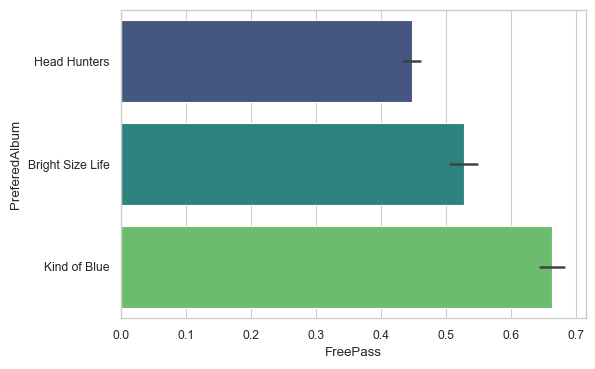

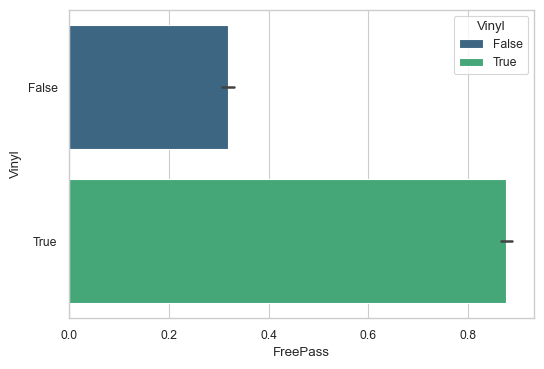

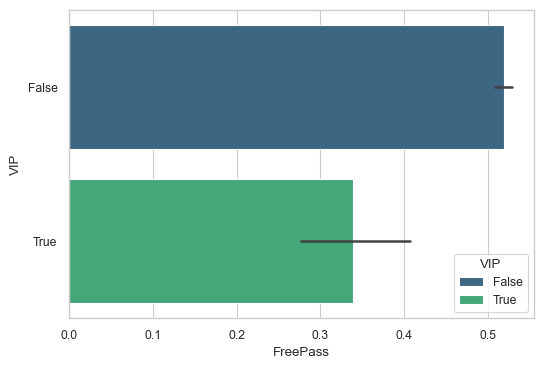

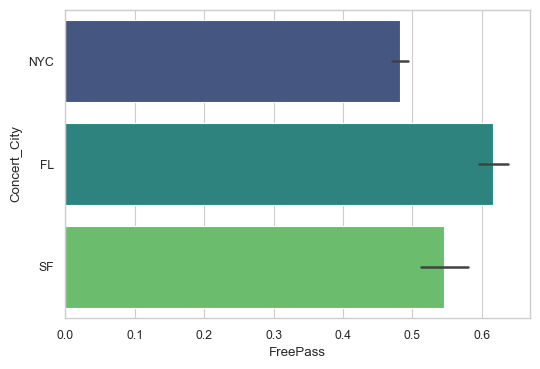

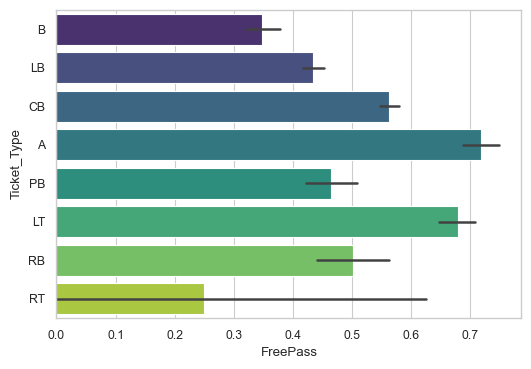

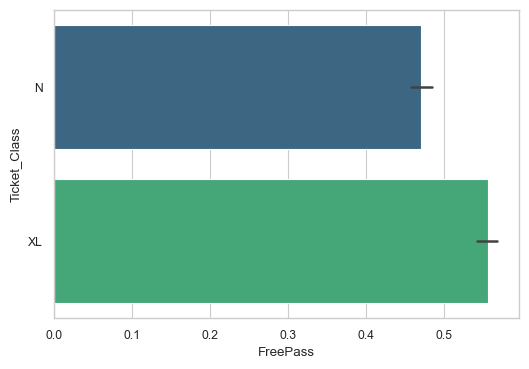

In [10]:
for col in still_not_number_cols:
    plt.figure()
    sns.barplot(x='FreePass', y=col, hue=col, data=data, palette='viridis', orient='h')
    plt.show()


So we can get dummy variables for all of them

In [11]:
# Create dummy variables (One-Hot Encoding)
# drop_first=True avoids multicollinearity (e.g., if not Male, then Female)
df_encoded = pd.get_dummies(data, columns=still_not_number_cols, drop_first=True)

# Drop the rest of columns we don't need anymore
df_final = df_encoded.drop(columns=['Id', 'Opinion', 'TicketInfo'])

# Preview final numeric table
print(f"New shape: {df_final.shape}")
df_final.head()

New shape: (10116, 23)


,AvgTime,Age,Food,Drinks,FreePass,Opinion_Polarity,Concert_StartTime,Concert_EndTime,Concert_Duration,PreferedAlbum_Head Hunters,...,Concert_City_NYC,Concert_City_SF,Ticket_Type_B,Ticket_Type_CB,Ticket_Type_LB,Ticket_Type_LT,Ticket_Type_PB,Ticket_Type_RB,Ticket_Type_RT,Ticket_Class_XL
0,3.055,22.0,170.0,1.0,True,0.100000,12.0,5.0,5.0,True,...,True,False,True,False,False,False,False,False,False,False
1,2.510,9.0,0.0,0.0,True,-0.166667,12.0,5.0,5.0,False,...,True,False,False,False,True,False,False,False,False,False
2,0.803,27.0,815.0,37.0,False,-0.125000,12.0,5.0,5.0,True,...,True,False,False,True,False,False,False,False,False,False
3,0.568,36.0,1427.0,1395.0,False,0.000000,16.0,7.0,3.0,False,...,False,False,False,False,False,False,False,False,False,True
4,0.034,16.0,1299.0,0.0,False,0.000000,12.0,5.0,5.0,False,...,True,False,True,False,False,False,False,False,False,True


Drinks is a bit unrealistic since one guy took 1400 drinks...

In [12]:
df_final.columns

Index(['AvgTime', 'Age', 'Food', 'Drinks', 'FreePass', 'Opinion_Polarity',
       'Concert_StartTime', 'Concert_EndTime', 'Concert_Duration',
       'PreferedAlbum_Head Hunters', 'PreferedAlbum_Kind of Blue',
       'Vinyl_True', 'VIP_True', 'Concert_City_NYC', 'Concert_City_SF',
       'Ticket_Type_B', 'Ticket_Type_CB', 'Ticket_Type_LB', 'Ticket_Type_LT',
       'Ticket_Type_PB', 'Ticket_Type_RB', 'Ticket_Type_RT',
       'Ticket_Class_XL'],
      dtype='object')

In [13]:
# Save the cleaned and preprocessed data
df_final.to_csv('../data/train_cleaned.csv', index=False)